## Documentation required info
---

Steps:
1. Load data and model
    * validate the model is the right one
2. Data Waterfall
3. Feature Importance
4. Generate SHAP plot
5. Segmeneted behaviors (should have been produced)

### Load Data and Model

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import src.monitoring.utils as mu
import src.monitoring.monitoring as mntr
import rdsutils.score_alignment as sa
import rdsutils

from rdsutils.data_waterfall import DataWaterfallReport 
import rdsutils.plot as rdsplot

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]  # monitoring config
rconfig = config["refitting_config"]  # refitting config

locals().update(rconfig)   # this would set k-v pairs in rconfig as local variables
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(rconfig.keys(), mconfig.keys())

dict_keys(['artifact_path', 'data_output_path', 'refitted_model_path', 'modeling_df_scored_path', 'test_df_scored_path']) dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [3]:
train_df = pd.read_parquet(modeling_df_scored_path)
test_df = pd.read_parquet(test_df_scored_path)

<AxesSubplot:>

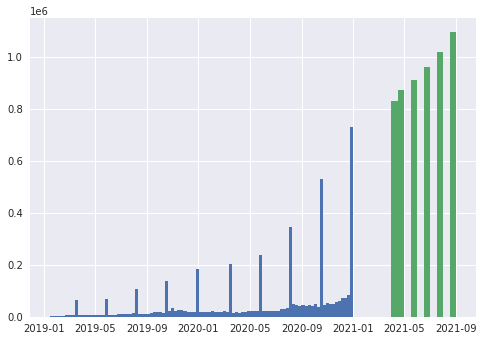

In [4]:
train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=10)

In [5]:
from smart_open import open

with open(refitted_model_path, "rb") as f:
    clf = pkl.load(f)
    
# load model from s3 and then save to .txt file
dt_str = train_df.sample_date.max().strftime('%Y-%m-%d')
clf.booster_.save_model(os.path.join(artifact_path, "refitting", f"refitted_model_{dt_str}.txt"))

FileNotFoundError: [Errno 2] No such file or directory: '../../artifacts/monitoring-2022Q1/refitting/refitted_model_2020-12-31.txt'

#### Make sure it is the right model

By Plotting things

In [ ]:
def plot_score_distr(df, score1, score2, ax, title):
    df[score1].hist(bins=50, alpha=0.4, label=score1, ax=ax)
    df[score2].hist(bins=50, alpha=0.4, label=score2, ax=ax)
    ax.set_title(title)
    ax.legend()
    

### Data Waterfall
---

In [ ]:
def drop_account_with_no_trans_in_next_60d(df):
    condition = (df["nr_transactions_next_60d"] == 0)
    return df[~condition]
    
def drop_bad_but_pos_balance(df):
    condition = (df["target"] & (df["latest_acc_bal"] > 0))
    return df[~condition]

def drop_good_but_chg_wrt_off(df):
    condition = (~df[f'target'] & (~df["chg_wrt_off_date"].isna()))
    return df[~condition]

def drop_good_but_neg_balance(df):
    condition = (~df["target"] & (df["latest_acc_bal"] < 0))
    return df[~condition]

def drop_good_but_account_closed(df):
    condition = (~df["target"] & df["closed_reason"].isin(  # 4
                    [
                        "Closed by SoFi - Risk Request",
                        "Closed by SoFi - Charge-Off / Write-Off",
                    ]
                ))
    return df[~condition]

def drop_account_restricted_on_sample_date(df):
    condition = (~df["target"] & df["restricted_reason"].str.startswith("No"))
    return df[~condition]

In [ ]:
train_df[["is_static", "indeterminate"]].value_counts()

In [ ]:
artifact_path

In [ ]:
# static data
fns = [drop_account_with_no_trans_in_next_60d,
        drop_bad_but_pos_balance,
        drop_good_but_chg_wrt_off,
        drop_good_but_neg_balance,
        drop_good_but_account_closed,
        drop_account_restricted_on_sample_date]

wf = DataWaterfallReport(train_df[train_df.is_static], fns, 'target') 
waterfall = wf.get_report(True)
waterfall.to_csv(os.path.join(artifact_path, "refitting", "data_waterfall_static.csv"))
waterfall

In [ ]:
# dynamic data

fns = [drop_bad_but_pos_balance,
        drop_good_but_chg_wrt_off,
        drop_good_but_neg_balance,
        drop_good_but_account_closed,
        drop_account_restricted_on_sample_date]

wf = DataWaterfallReport(train_df[~train_df.is_static], fns, 'target') 
waterfall = wf.get_report(True)
waterfall.to_csv(os.path.join(artifact_path, "refitting", "data_waterfall_dynamic.csv"))
waterfall

In [ ]:
train_df[~train_df.indeterminate].target.value_counts()

### Feature Importance
---

In [ ]:
fig, axs = rdsplot.display_feature_importance(clf.feature_name_,
                                   clf.feature_importances_, 
                                   max_n_features=-1, figsize=(20,10)) 
fpath = os.path.join(artifact_path, "refitting", "feature_importance.png")
fig.savefig(fpath)

### Generate SHAP plot
---

In [14]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, place_holder=True, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()
    placeholder_i = 0
    for i in range(len(features)):
        feature = features[i]
        
#         if place_holder and feature == 'phone_risk_score':
#             placeholder_i = 1
        ax = axs[i]
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
            
    return fig

In [15]:
features_by_imp = sorted(zip(clf.feature_importances_, clf.feature_name_), reverse=True)
features_by_imp = list(zip(*features_by_imp))[1]
features_by_imp = list(features_by_imp)

In [16]:
%%time 
import shap

shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_df[clf.feature_name_])

CPU times: user 5h 35min 7s, sys: 4.7 s, total: 5h 35min 12s
Wall time: 4min 10s


CPU times: user 48.2 s, sys: 12.8 s, total: 1min
Wall time: 1min


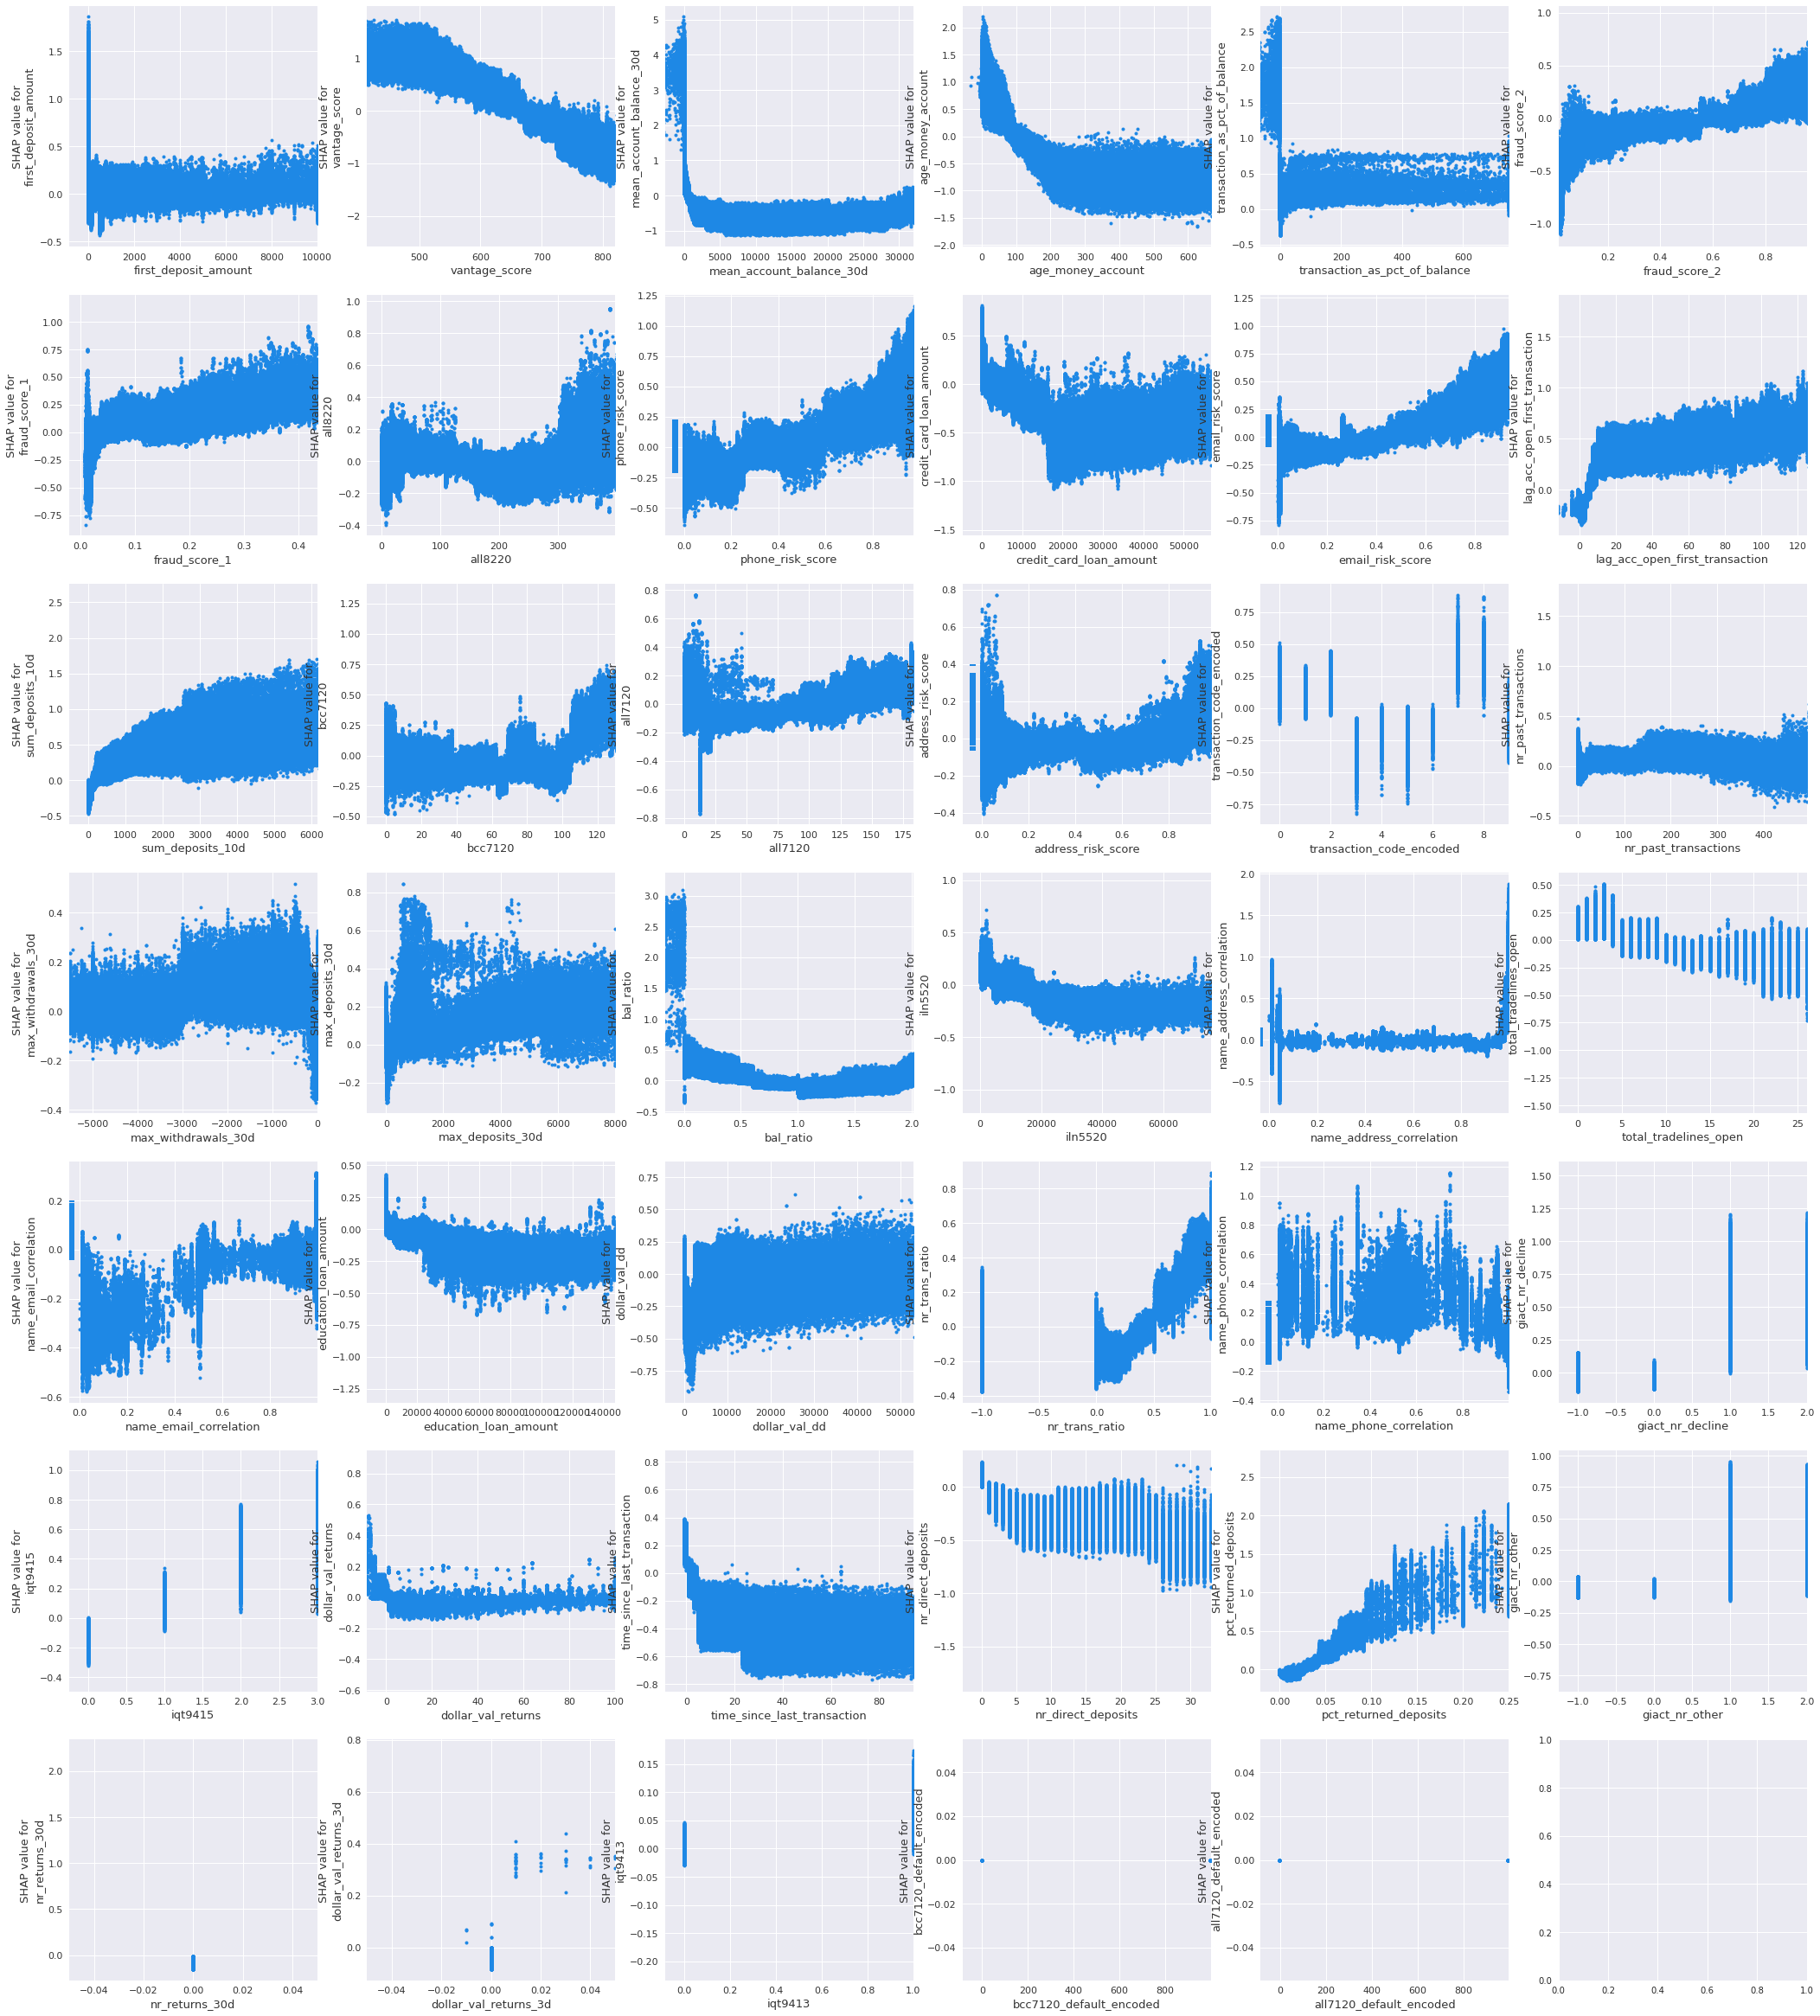

In [17]:
%time fig = get_shap_dependence(train_df[clf.feature_name_], shap_values[1], features_by_imp, interaction_index=None)

In [18]:
fpath = os.path.join(artifact_path, "refitting", "shap_values.png")
fig.savefig(fpath)